# Run PESTPP-IES

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import pyemu


flopy is installed in /Users/jeremyw/Dev/flopy/flopy


In [2]:
t_d = "template"
m_d = "master_ies"

In [3]:
pst = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
pst.write_par_summary_table(filename="none")

,type,transform,count,initial value,upper bound,lower bound,standard deviation
grvka4,grvka4,log,705,0,1,-1,0.5
pp_ss0,pp_ss0,log,67,0,1,-1,0.5
sy7_cn,sy7_cn,log,1,0,0.243038,-0.60206,0.211275
pp_hk2,pp_hk2,log,67,0,1,-1,0.5
vka7_cn,vka7_cn,log,1,0,1,-1,0.5
grsy5,grsy5,log,705,0,0.243038,-0.60206,0.211275
grhk3,grhk3,log,705,0,1,-1,0.5
pp_ss1,pp_ss1,log,67,0,1,-1,0.5
pp_sy1,pp_sy1,log,67,0,0.243038,-0.60206,0.211275
hk8_cn,hk8_cn,log,1,0,1,-1,0.5


### Run PESTPP-IES in original mode and post process

In [30]:
pst.pestpp_options["ies_num_reals"] = 100
pst.pestpp_options["ies_par_en"] = "sweep_in.csv"
pst.control_data.noptmax = 3

In [31]:
pst.write(os.path.join(t_d,"freyberg_ies.pst"))

In [32]:
pyemu.os_utils.start_slaves(t_d,"pestpp-ies","freyberg_ies.pst",num_slaves=20,master_dir=m_d)

In [42]:
oe_pr = pd.read_csv(os.path.join(m_d,"freyberg_ies.0.obs.csv"),index_col=0)
oe_pt = pd.read_csv(os.path.join(m_d,"freyberg_ies.{0}.obs.csv".format(pst.control_data.noptmax)),index_col=0)

FileNotFoundError: File b'master_ies/freyberg_ies.0.obs.csv' does not exist

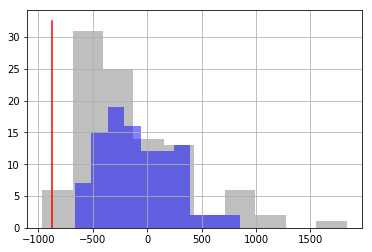

In [34]:
obs = pst.observation_data
swgws = obs.loc[obs.obsnme.apply(lambda x: "fa_hw" in x),"obsnme"]
for swgw in swgws:
    ax = plt.subplot(111)
    oe_pr.loc[:,swgw].hist(ax=ax,color="0.5",alpha=0.5)
    oe_pt.loc[:,swgw].hist(ax=ax,color="b",alpha=0.5)
    ax.plot([obs.loc[swgw,"obsval"],obs.loc[swgw,"obsval"]],ax.get_ylim(),"r")
    ax.set_title(swgw)
    plt.show()

Damn!  What happened? 

In [35]:
pe_pr = pd.read_csv(os.path.join(m_d,"freyberg_ies.0.par.csv"),index_col=0)
pe_pt = pd.read_csv(os.path.join(m_d,"freyberg_ies.{0}.par.csv".format(pst.control_data.noptmax)),index_col=0)

/Users/jeremyw/miniconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<Figure size 576x756 with 0 Axes>

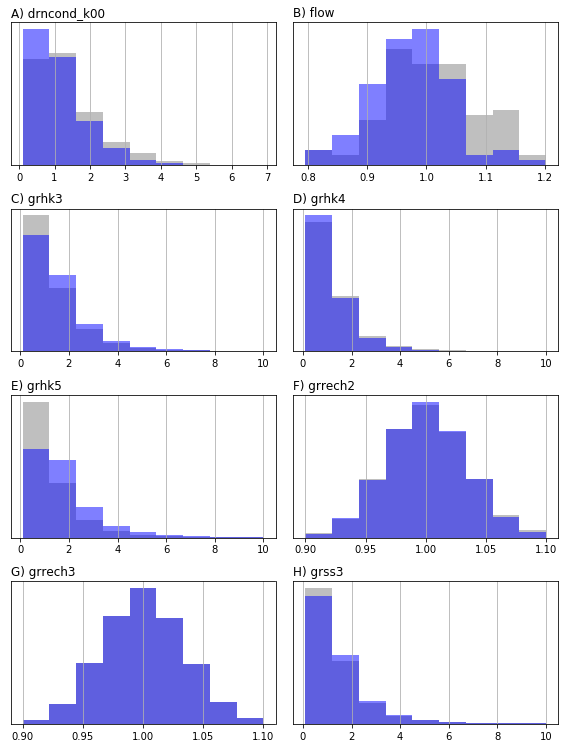

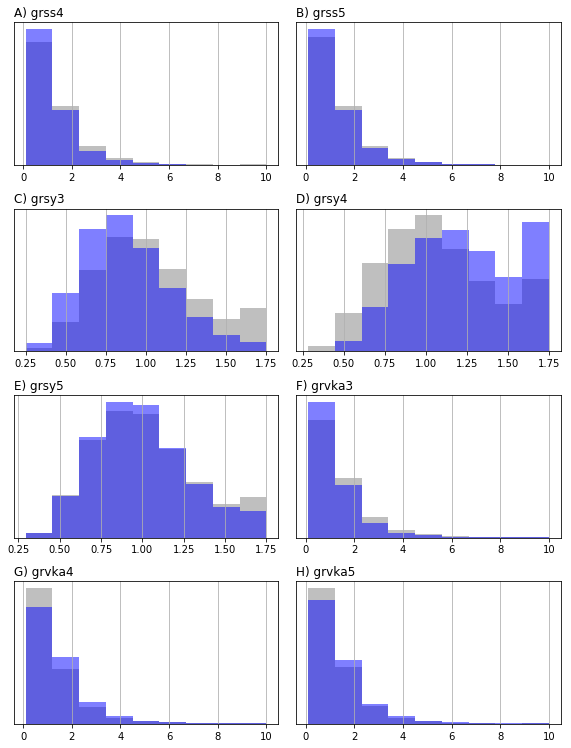

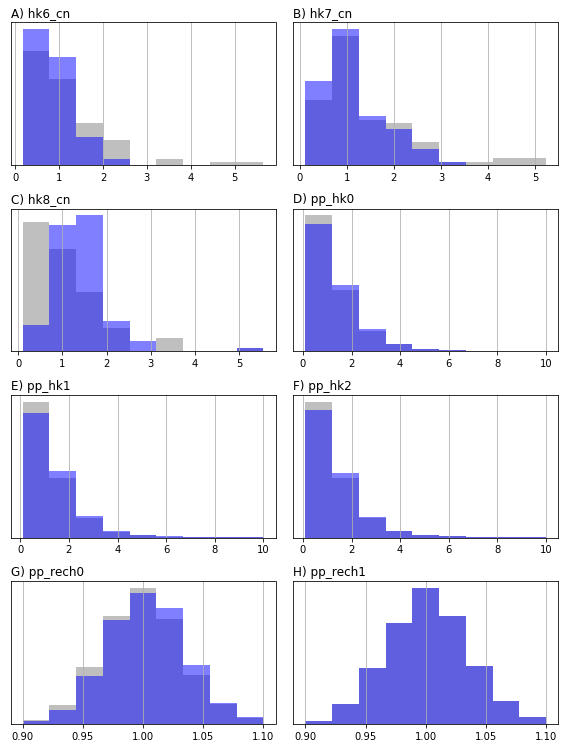

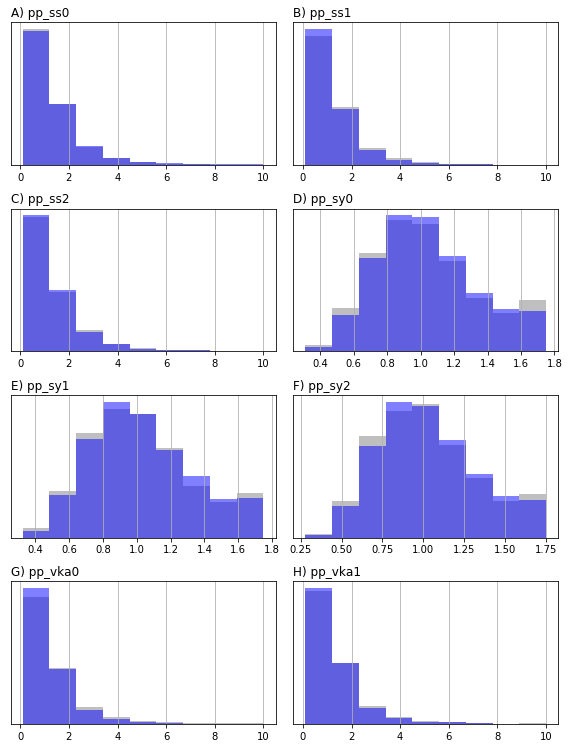

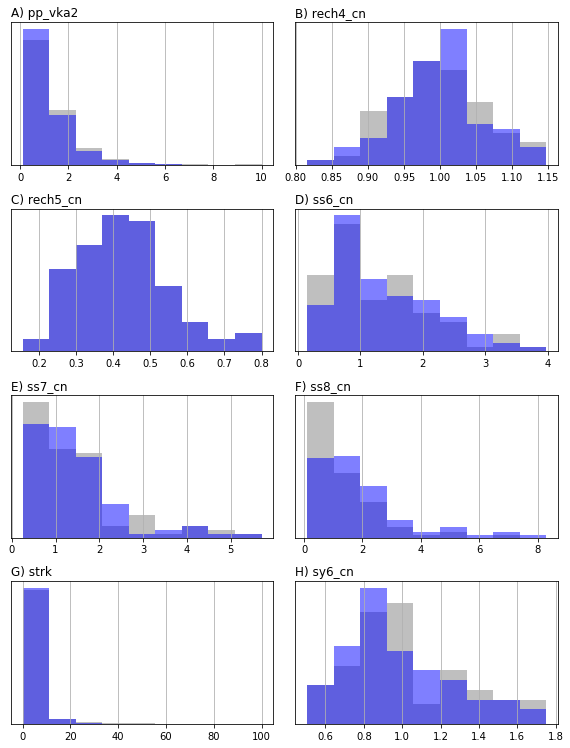

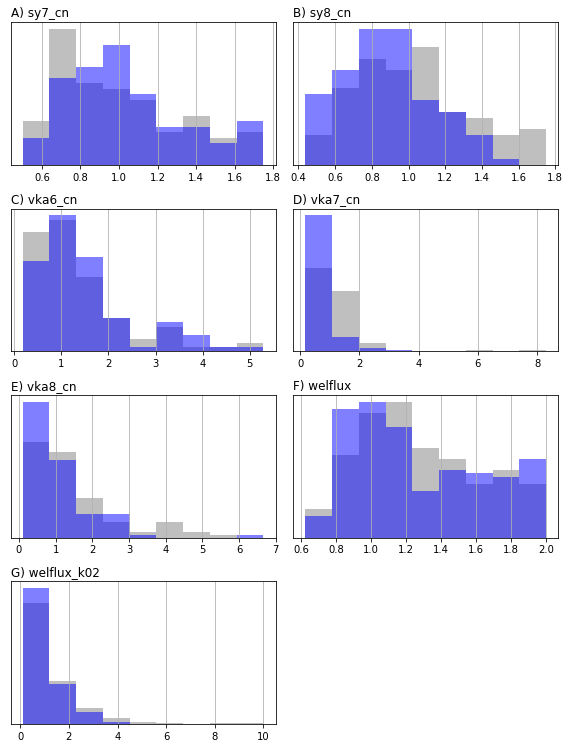

In [36]:
par = pst.parameter_data
pdict = par.groupby("pargp").groups
pyemu.plot_utils.ensemble_helper({"0.5":pe_pr,"b":pe_pt},plot_cols=pdict)

### PESTPP-IES with simple temporal localization

In [37]:

scen_groups = ["grrech3","pp_rech1","rech5_cn"]
scen_pars = par.loc[par.pargp.apply(lambda x: x in scen_groups),"parnme"].tolist()
scen_pars.append("welflux_001")


In [38]:
loc = pyemu.Matrix.from_names(pst.nnz_obs_names,pst.par_groups).to_dataframe()
loc.loc[:,:]= 1.0
loc.loc[:,scen_groups] = 0.0
pyemu.Matrix.from_dataframe(loc).to_ascii(os.path.join(t_d,"loc.mat"))

In [39]:
pst.pestpp_options["ies_localizer"] = "loc.mat"
pst.write(os.path.join(t_d,"freyberg_ies_loc.pst"))
pyemu.os_utils.start_slaves(t_d,"pestpp-ies","freyberg_ies_loc.pst",num_slaves=20,master_dir=m_d)

In [44]:
oe_pr = pd.read_csv(os.path.join(m_d,"freyberg_ies_loc.0.obs.csv"),index_col=0)
oe_pt = pd.read_csv(os.path.join(m_d,"freyberg_ies_loc.{0}.obs.csv".format(pst.control_data.noptmax)),index_col=0)

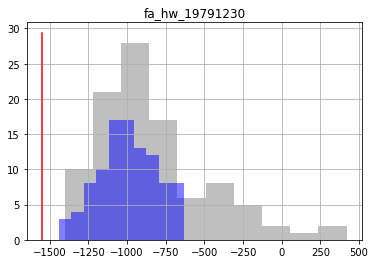

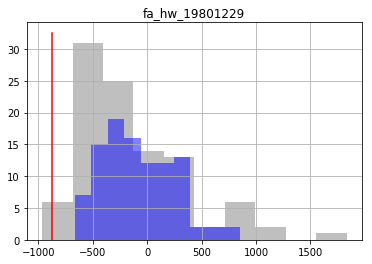

In [47]:
obs = pst.observation_data
swgws = obs.loc[obs.obsnme.apply(lambda x: "fa_hw" in x),"obsnme"]
for swgw in swgws:
    ax = plt.subplot(111)
    oe_pr.loc[:,swgw].hist(ax=ax,color="0.5",alpha=0.5)
    oe_pt.loc[:,swgw].hist(ax=ax,color="b",alpha=0.5)
    ax.plot([obs.loc[swgw,"obsval"],obs.loc[swgw,"obsval"]],ax.get_ylim(),"r")
    ax.set_title(swgw)
    plt.show()

### PESTPP-IES with par-by-par distance based localization

In [63]:
m = flopy.modflow.Modflow.load("freyberg.nam",model_ws="template")


In [70]:
par = pst.parameter_data
gr_par = par.loc[par.pargp.apply(lambda x: "gr" in x),:].copy()
gr_par.groupby("pargp").groups
gr_par.loc[:,"i"] = gr_par.parnme.apply(lambda x: int(x[-6:-3]))
gr_par.loc[:,"j"] = gr_par.parnme.apply(lambda x: int(x[-3:]))
gr_par.loc[:,"x"] = gr_par.apply(lambda x: m.sr.xcentergrid[x.i,x.j],axis=1)
gr_par.loc[:,"y"] = gr_par.apply(lambda x: m.sr.ycentergrid[x.i,x.j],axis=1)

nobs = pst.observation_data.loc[pst.nnz_obs_names,:].copy()
nobs.loc[:,"i"] = nobs.obsnme.apply(lambda x: int(x.split('_')[2]))
nobs.loc[:,"j"] = nobs.obsnme.apply(lambda x: int(x.split('_')[3]))
nobs.loc[:,"x"] = nobs.apply(lambda x: m.sr.xcentergrid[x.i,x.j],axis=1)
nobs.loc[:,"y"] = nobs.apply(lambda x: m.sr.ycentergrid[x.i,x.j],axis=1)

pp_tpl = [f for f in os.listdir(t_d) if "pp" in f and f.endswith(".tpl")]
pp_tpl_dfs = [pyemu.pp_utils.pp_tpl_to_dataframe(os.path.join(t_d,f)) for f in pp_tpl]
pp_par = pd.concat(pp_tpl_dfs)
pp_par.index = pp_par.parnme
#pp_par = par.loc[par.pargp.apply(lambda x: "pp" in x),:].copy()


In [97]:
loc = pyemu.Matrix.from_names(pst.nnz_obs_names,pst.par_names).to_dataframe()
loc.loc[:,:] = 1.0
for oname in pst.nnz_obs_names:
#     i,j = nobs.loc[oname,["i","j"]]
#     gr_par.loc[:,'idiff'] = (gr_par.i - i).apply(np.abs)
#     gr_par.loc[:,'jdiff'] = (gr_par.j - j).apply(np.abs)
#     print(oname,gr_par.idiff.min(),gr_par.jdiff.min())
#     too_far = gr_par.loc[gr_par.apply(lambda x: x.idiff > 4 or x.jdiff > 4,axis=1),"parnme"]
#     loc.loc[:,too_far] = 0.0
    xx,yy = nobs.loc[oname,['x','y']]
    
    gr_par.loc[:,"dist"] = gr_par.apply(lambda x: (x.x - xx)**2 + (x.y - yy)**2,axis=1).apply(np.sqrt)
    gr_too_far = gr_par.loc[gr_par.dist > 5000,"parnme"]
    loc.loc[:,gr_too_far] = 0.0
    
    pp_par.loc[:,"dist"] = pp_par.apply(lambda x: (x.x - xx)**2 + (x.y - yy)**2,axis=1).apply(np.sqrt)
    pp_too_far = pp_par.loc[pp_par.dist > 5000,"parnme"]
    loc.loc[:,pp_too_far] = 0.0
    print(oname,gr_too_far.shape,pp_too_far.shape)
    
loc.loc[:,scen_pars] = 0.0
loc.sum(axis=1)

hds_00_002_009_000 (4578,) (462,)
hds_00_002_015_000 (4732,) (476,)
hds_00_003_008_000 (4326,) (406,)
hds_00_009_001_000 (3262,) (266,)
hds_00_013_010_000 (1512,) (140,)
hds_00_015_016_000 (1372,) (112,)
hds_00_021_010_000 (686,) (70,)
hds_00_022_015_000 (1204,) (126,)
hds_00_024_004_000 (1764,) (168,)
hds_00_026_006_000 (2170,) (196,)
hds_00_029_015_000 (2954,) (280,)
hds_00_033_007_000 (3780,) (364,)
hds_00_034_010_000 (3948,) (378,)


hds_00_002_009_000    1124.0
hds_00_002_015_000    1124.0
hds_00_003_008_000    1124.0
hds_00_009_001_000    1124.0
hds_00_013_010_000    1124.0
hds_00_015_016_000    1124.0
hds_00_021_010_000    1124.0
hds_00_022_015_000    1124.0
hds_00_024_004_000    1124.0
hds_00_026_006_000    1124.0
hds_00_029_015_000    1124.0
hds_00_033_007_000    1124.0
hds_00_034_010_000    1124.0
dtype: float64

In [98]:
pyemu.Matrix.from_dataframe(loc).to_binary(os.path.join(t_d,"loc.jcb"))
pst.pestpp_options["ies_localizer"] = "loc.jcb"
pst.write(os.path.join(t_d,"freyberg_ies_loc2.pst"))

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
<class 'numpy.ndarray'>


In [99]:
pyemu.os_utils.start_slaves(t_d,"pestpp-ies","freyberg_ies_loc2.pst",num_slaves=20,master_dir=m_d)

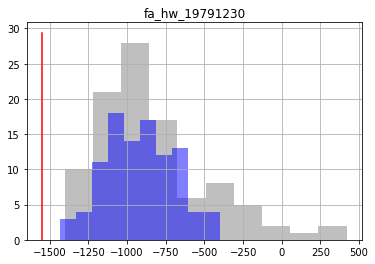

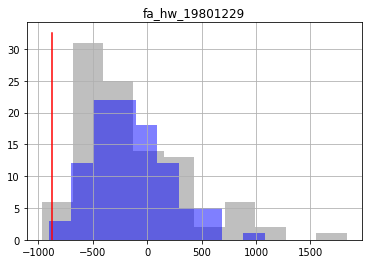

In [100]:
oe_pr = pd.read_csv(os.path.join(m_d,"freyberg_ies_loc2.0.obs.csv"),index_col=0)
oe_pt = pd.read_csv(os.path.join(m_d,"freyberg_ies_loc2.{0}.obs.csv".format(pst.control_data.noptmax)),index_col=0)
obs = pst.observation_data
swgws = obs.loc[obs.obsnme.apply(lambda x: "fa_hw" in x),"obsnme"]
for swgw in swgws:
    ax = plt.subplot(111)
    oe_pr.loc[:,swgw].hist(ax=ax,color="0.5",alpha=0.5)
    oe_pt.loc[:,swgw].hist(ax=ax,color="b",alpha=0.5)
    ax.plot([obs.loc[swgw,"obsval"],obs.loc[swgw,"obsval"]],ax.get_ylim(),"r")
    ax.set_title(swgw)
    plt.show()